           State  Year Type_code                                     Type  \
0  A & N Islands  2001    Causes                       Illness (Aids/STD)   
1  A & N Islands  2001    Causes  Bankruptcy or Sudden change in Economic   
2  A & N Islands  2001    Causes  Cancellation/Non-Settlement of Marriage   
3  A & N Islands  2001    Causes        Physical Abuse (Rape/Incest Etc.)   
4  A & N Islands  2001    Causes                            Dowry Dispute   

   Gender Age_group  Total  
0  Female      0-14      0  
1  Female      0-14      0  
2  Female      0-14      0  
3  Female      0-14      0  
4  Female      0-14      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237519 entries, 0 to 237518
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   State      237519 non-null  object
 1   Year       237519 non-null  int64 
 2   Type_code  237519 non-null  object
 3   Type       237519 non-null  object
 4   Gender  

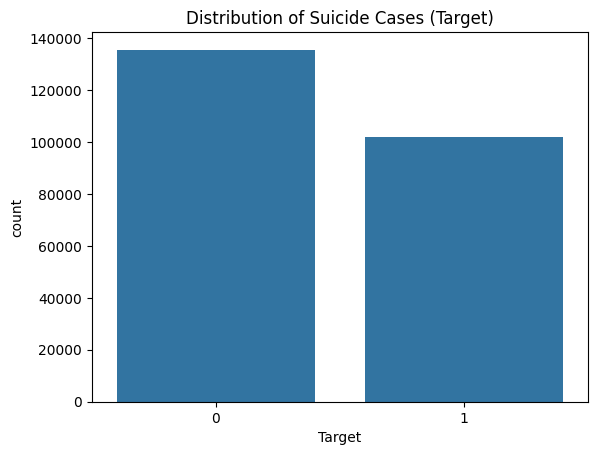

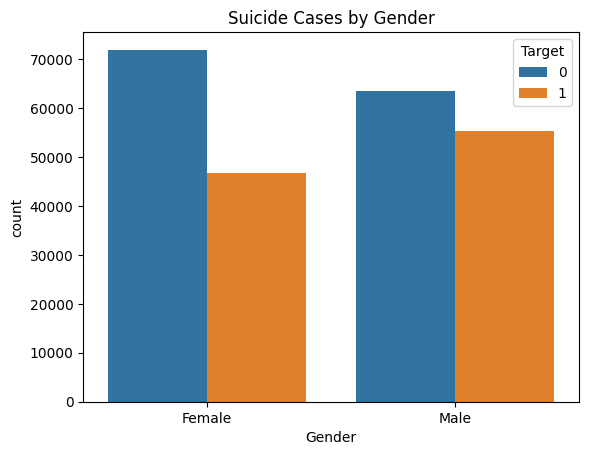

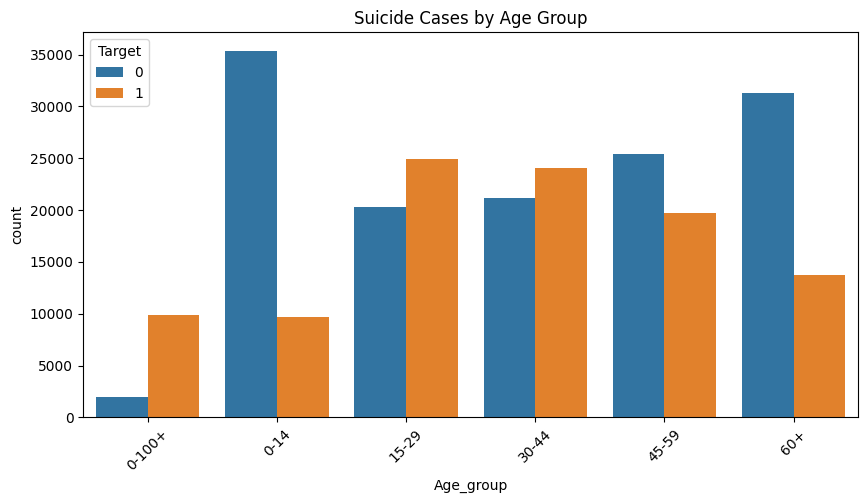

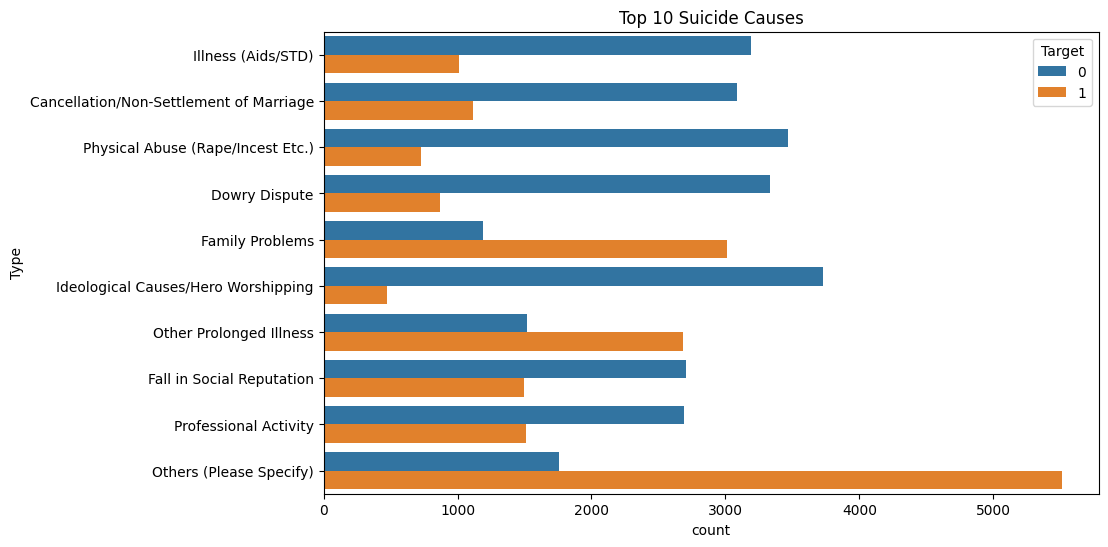

✅ Accuracy: 0.835971707645672
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86     27046
           1       0.82      0.80      0.81     20458

    accuracy                           0.84     47504
   macro avg       0.83      0.83      0.83     47504
weighted avg       0.84      0.84      0.84     47504



['scaler.pkl']

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Step 2: Load Dataset
df = pd.read_csv("Suicides in India 2001-2012.csv")  # Replace with your file path
print(df.head())
print(df.info())
print(df.describe())

# Step 3: Basic Data Cleaning (optional, as needed)
df = df.dropna()  # Drop rows with missing values (if any)

# Step 4: Create Binary Target Column
# If 'Total' > 0, we mark it as 1 (case reported), else 0
df["Target"] = df["Total"].apply(lambda x: 1 if x > 0 else 0)

# Step 5: Data Visualization

# 5.1 Target distribution
sns.countplot(x="Target", data=df)
plt.title("Distribution of Suicide Cases (Target)")
plt.show()

# 5.2 Gender vs Target
sns.countplot(x="Gender", hue="Target", data=df)
plt.title("Suicide Cases by Gender")
plt.show()

# 5.3 Age Group vs Target
plt.figure(figsize=(10, 5))
sns.countplot(x="Age_group", hue="Target", data=df, order=sorted(df["Age_group"].unique()))
plt.title("Suicide Cases by Age Group")
plt.xticks(rotation=45)
plt.show()

# 5.4 Top 10 Types
top_types = df["Type"].value_counts().nlargest(10).index
plt.figure(figsize=(10, 6))
sns.countplot(y="Type", data=df[df["Type"].isin(top_types)], hue="Target")
plt.title("Top 10 Suicide Causes")
plt.show()

# Step 6: Encode Categorical Variables
df_encoded = pd.get_dummies(df[["State", "Type", "Gender", "Age_group"]], drop_first=True)

# Step 7: Feature & Target Split
X = df_encoded
y = df["Target"]

# Step 8: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 10: Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 11: Evaluate the Model
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Classification Report:\n", classification_report(y_test, y_pred))
import joblib

# Save
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')



In [2]:
%%writefile app.py

# In app.py, load with:
# model = joblib.load('model.pkl')
# scaler = joblib.load('scaler.pkl')
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Step 1: Load & Prepare Dataset
@st.cache_data
def load_data():
    df = pd.read_csv("Suicides in India 2001-2012.csv")
    df = df.dropna()
    df["Target"] = df["Total"].apply(lambda x: 1 if x > 0 else 0)
    return df

df = load_data()

# Step 2: Encode Features for Model Training
df_encoded = pd.get_dummies(df[["State", "Type", "Gender", "Age_group"]], drop_first=True)
X = df_encoded
y = df["Target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

# Streamlit App UI
st.title("🧠 Suicide Case Prediction in India")
st.write("Predict whether a suicide case is reported based on the inputs.")

# Sidebar for User Input
st.sidebar.header("📝 Enter Details")
state = st.sidebar.selectbox("State", sorted(df["State"].unique()))
type_ = st.sidebar.selectbox("Type", sorted(df["Type"].unique()))
gender = st.sidebar.selectbox("Gender", df["Gender"].unique())
age_group = st.sidebar.selectbox("Age Group", sorted(df["Age_group"].unique()))

# Prepare User Input
user_input = pd.DataFrame([[state, type_, gender, age_group]], columns=["State", "Type", "Gender", "Age_group"])
combined = pd.concat([df[["State", "Type", "Gender", "Age_group"]], user_input], axis=0)

# One-Hot Encode all
encoded_combined = pd.get_dummies(combined, drop_first=True)

# Ensure columns match training
encoded_combined = encoded_combined.reindex(columns=df_encoded.columns, fill_value=0)

# Extract user input row
input_scaled = scaler.transform(encoded_combined.tail(1))

# Predict
prediction = model.predict(input_scaled)[0]

st.sidebar.subheader("🔍 Prediction")
if prediction == 1:
    st.sidebar.success("✅ Suicide Reported")
else:
    st.sidebar.warning("🚫 No Suicide Reported")

# Show accuracy
accuracy = accuracy_score(y_test, model.predict(X_test))
st.sidebar.markdown(f"**Model Accuracy:** `{accuracy:.2f}`")

# Data Visualizations
st.header("📊 Suicide Case Visualizations")

st.subheader("1. Target Distribution")
fig1, ax1 = plt.subplots()
sns.countplot(x="Target", data=df, ax=ax1)
st.pyplot(fig1)

st.subheader("2. Suicide Cases by Gender")
fig2, ax2 = plt.subplots()
sns.countplot(x="Gender", hue="Target", data=df, ax=ax2)
st.pyplot(fig2)

st.subheader("3. Suicide Cases by Age Group")
fig3, ax3 = plt.subplots(figsize=(10, 4))
sns.countplot(x="Age_group", hue="Target", data=df, order=sorted(df["Age_group"].unique()), ax=ax3)
plt.xticks(rotation=45)
st.pyplot(fig3)

st.subheader("4. Top 10 Suicide Causes")
top_types = df["Type"].value_counts().nlargest(10).index
fig4, ax4 = plt.subplots(figsize=(10, 6))
sns.countplot(y="Type", data=df[df["Type"].isin(top_types)], hue="Target", ax=ax4)
st.pyplot(fig4)


Overwriting app.py


In [ ]:
!streamlit run app.py